In [56]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

#Model

In [57]:
class LNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.V = MLP_V()

  def forward(self, theta, omega):
    T = (1/2) * omega**2
    V = self.V(theta.unsqueeze(1)).squeeze()
    return T - V

class MLP_V(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(1, 128),
        nn.Tanh(),
        nn.Linear(128, 1),
    )

  def forward(self, theta):
    return self.net(theta)

#Training Loop

In [58]:
def lagrangian_dynamics(model, theta, omega):
  theta = theta.requires_grad_(True)
  omega = omega.requires_grad_(True)

  L = model(theta,omega).sum()

  dL_dtheta = torch.autograd.grad(L, theta, create_graph=True)[0]
  dL_domega = torch.autograd.grad(L, omega, create_graph=True)[0]

  d2L_d2omega = torch.autograd.grad(dL_domega.sum(), omega, create_graph=True)[0]

  eps = 1e-6
  domega = dL_dtheta / (d2L_d2omega + eps)
  dtheta = omega

  return dtheta,domega


In [59]:
#-------------
# Load data
#-------------

data = np.load("5.1_LNN_dataset.npz")
split = np.load("5.2_splits_LNN.npz")

X = np.hstack(data["X"])
X = X.reshape(15000, 2)
Y = data["Y"]
Y = Y.reshape(15000, 2)
print(X.shape)
print(Y.shape)

#----------------
# Split data
#----------------

X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

#-------------------
# Convert to tensor
#-------------------

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#---------
#  Model
#---------

model = LNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

#----------------
# Training loop
#----------------

n_epochs = 750

for epoch in range(n_epochs):
  model.train()
  train_loss = 0.0

  for X_batch, Y_batch in train_loader:

    theta = X_batch[:, 0]
    omega = X_batch[:, 1]

    dtheta_pred, domega_pred = lagrangian_dynamics(model, theta, omega)

    loss = (
        loss_fn(dtheta_pred, Y_batch[:,0]) +
        loss_fn(domega_pred, Y_batch[:,1])
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    train_loss += loss.item()

  train_loss /= len(train_loader)


  model.eval()
  test_loss = 0.0

  for X_batch, Y_batch in test_loader:
      theta = X_batch[:,0]
      omega = X_batch[:,1]

      dtheta_pred, domega_pred = lagrangian_dynamics(model, theta, omega)

      loss = (
        loss_fn(dtheta_pred, Y_batch[:,0]) +
        loss_fn(domega_pred, Y_batch[:,1])
      )
      test_loss += loss.item()

  test_loss /= len(test_loader)
  print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#-------------
# Save model
#-------------

torch.save(model.state_dict(), "LNN.pth")

(15000, 2)
(15000, 2)
Epoch 1/750, Train Loss: 23.5628, Test Loss: 15.7210
Epoch 2/750, Train Loss: 12.1595, Test Loss: 8.9518
Epoch 3/750, Train Loss: 7.3006, Test Loss: 6.2952
Epoch 4/750, Train Loss: 5.6373, Test Loss: 5.6078
Epoch 5/750, Train Loss: 5.2471, Test Loss: 5.4295
Epoch 6/750, Train Loss: 5.1171, Test Loss: 5.3420
Epoch 7/750, Train Loss: 5.0441, Test Loss: 5.2790
Epoch 8/750, Train Loss: 4.9841, Test Loss: 5.2260
Epoch 9/750, Train Loss: 4.9276, Test Loss: 5.1688
Epoch 10/750, Train Loss: 4.8813, Test Loss: 5.1195
Epoch 11/750, Train Loss: 4.8261, Test Loss: 5.0640
Epoch 12/750, Train Loss: 4.7740, Test Loss: 5.0077
Epoch 13/750, Train Loss: 4.7120, Test Loss: 4.9385
Epoch 14/750, Train Loss: 4.6437, Test Loss: 4.8757
Epoch 15/750, Train Loss: 4.5510, Test Loss: 4.7340
Epoch 16/750, Train Loss: 4.3894, Test Loss: 4.5665
Epoch 17/750, Train Loss: 4.2439, Test Loss: 4.4140
Epoch 18/750, Train Loss: 4.0761, Test Loss: 4.2706
Epoch 19/750, Train Loss: 3.9827, Test Loss: 4.2

#Results

In [60]:
def pendulum_dynamics(x, u, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  theta, omega = x
  m, l, g = params["m"], params["l"], params["g"]
  u = float(u)

  d_theta = omega
  d_omega = (g/l) * np.sin(theta) + u/(m * l**2)

  return np.array([d_theta, d_omega])

def rk4_step(f, x, u, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  k1 = f(x, u, params)
  k2 = f(x + 0.5 * dt * k1, u, params)
  k3 = f(x + 0.5 * dt * k2, u, params)
  k4 = f(x + dt * k3, u, params)

  return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, u_control, dt, T, params):  # Compute the trajectory using rk4_step at each step
  N = int(T/dt)
  x = np.zeros((N+1, 2))
  x[0] = x0

  for t in range(N):
    u = u_control(t * dt, x[t])
    x[t+1] = rk4_step(pendulum_dynamics, x[t], u, dt, params)
  return x


def zero_control(t,x):
  return 0

def rk4_step_LNN(model, x, dt):
    if x.dim() == 1:
        x = x.unsqueeze(0)
    def f(x):
        theta, omega = x[:,0], x[:,1]
        dtheta, domega = lagrangian_dynamics(model, theta, omega)
        return torch.stack([dtheta, domega], dim=1)

    k1 = f(x)
    k2 = f(x + 0.5 * dt * k1)
    k3 = f(x + 0.5 * dt * k2)
    k4 = f(x + dt * k3)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation_LNN(x0, dt, T):  # adapted version for the HNN
    N = int(T / dt)
    x = torch.zeros((N+1, 2))
    x[0] = torch.tensor(x0, dtype=torch.float32)

    for t in range(N):
        x[t+1] = rk4_step_LNN(model, x[t], dt).detach()

    return x.detach().numpy()


(501, 2)
(501, 2)
(501,)


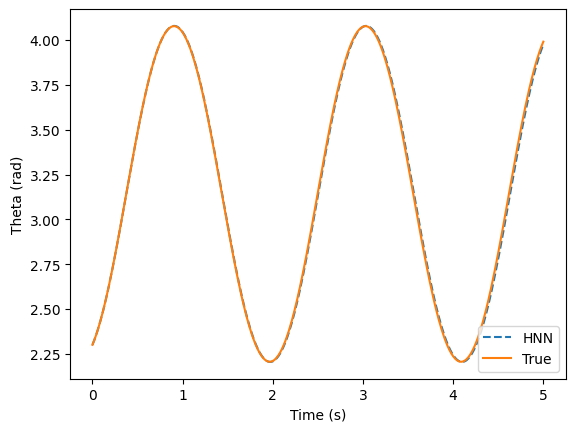

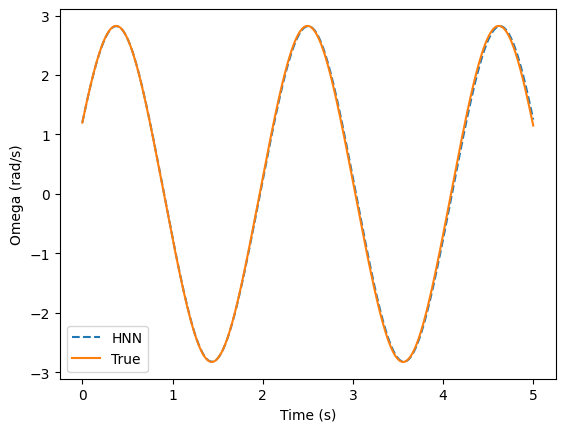

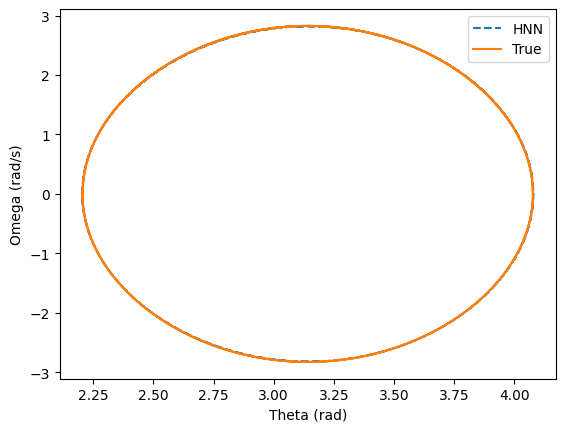

In [62]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

x0 = [2.3, 1.2]

HNN_trajectory = []
true_trajectory = []
T = 5.0 # 5s
dt = 0.01 # 500 step

#--------------
# Trajectories
#--------------

HNN_trajectory = trajectory_simulation_LNN(x0, dt, T)

true_trajectory = trajectory_simulation(x0, zero_control, dt, T, params=params)

#-------
# Plot
#-------

t = np.arange(start=0, stop = 5.001, step = dt)

print(HNN_trajectory.shape)
print(true_trajectory.shape)
print(t.shape)

plt.plot(t, np.array(HNN_trajectory)[:,0], "--")
plt.plot(t, np.array(true_trajectory)[:,0])
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend(["HNN", "True"])
plt.show()

plt.plot(t, np.array(HNN_trajectory)[:,1], "--")
plt.plot(t, np.array(true_trajectory)[:,1])
plt.xlabel("Time (s)")
plt.ylabel("Omega (rad/s)")
plt.legend(["HNN", "True"])
plt.show()

plt.figure()
plt.plot(np.array(HNN_trajectory)[:,0], np.array(HNN_trajectory)[:,1], "--")
plt.plot(np.array(true_trajectory)[:,0], np.array(true_trajectory)[:,1])
plt.legend(["HNN", "True"])
plt.xlabel("Theta (rad)")
plt.ylabel("Omega (rad/s)")
plt.show()
